## GDrive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/My Drive/Applied\ AI\ course\ Assignments/Case\ Study\ 1

/content/drive/My Drive/Applied AI course Assignments/Case Study 1


In [ ]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=177aeca0f83284c0bb225f60d08fea7f947d43c48b4c045413d53cc6383672d6
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, KFold

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor

from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import StackingRegressor
from bayes_opt import BayesianOptimization
from sklearn.linear_model import BayesianRidge

import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from math import sqrt

import joblib
import pickle
from prettytable import PrettyTable

from tqdm import tqdm_notebook as tqdm
import time
import gc
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#https://www.kaggle.com/fabiendaniel/elo-world
#Function to load data into pandas and reduce memory usage

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading the Data:

In [ ]:
train = reduce_mem_usage(pd.read_csv('New_Data_processed/train_features_without_merchant.csv', index_col=0))
test = reduce_mem_usage(pd.read_csv('New_Data_processed/test_features_without_merchant.csv', index_col=0))

Mem. usage decreased to 99.94 Mb (71.4% reduction)
Mem. usage decreased to 62.01 Mb (70.9% reduction)


In [ ]:
train.shape

(201917, 226)

In [ ]:
train.isna().sum().any()

False

In [ ]:
test.isna().any().sum() #target variable is Nan

3

In [ ]:
test.columns[test.isna().any()]

Index(['target', 'new_purchase_date_diff_now', 'new_last_buy'], dtype='object')

In [ ]:
test['new_purchase_date_diff_now'].fillna(test['new_purchase_date_diff_now'].mode()[0], inplace=True) 
test['new_last_buy'].fillna(test['new_last_buy'].mode()[0], inplace=True) 

In [ ]:
test.columns[test.isna().any()]

Index(['target'], dtype='object')

In [ ]:
y_train = train['target']
train_card_ids = train['card_id']
train.drop(columns=['card_id', 'target'], inplace=True, axis=1)
X_train = train

In [ ]:
columns = train.columns
columns = columns.drop('rare_datapoints')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 201917 entries, 0 to 201916
Columns: 224 entries, feature_1 to new_CLV
dtypes: float16(171), float32(5), float64(10), int16(15), int32(2), int8(21)
memory usage: 98.0 MB


In [ ]:
card_ids = test['card_id']
test.drop(columns=['card_id', 'target'], inplace= True, axis=1)

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123623 entries, 0 to 123622
Columns: 223 entries, feature_1 to new_CLV
dtypes: float16(171), float32(8), float64(9), int16(12), int32(3), int8(20)
memory usage: 60.1 MB


## Goss

In [ ]:
def LGB_CV_Bagging(
          max_depth,
          num_leaves,
          min_data_in_leaf,
          feature_fraction,
          bagging_fraction,
          lambda_l1,
          n_estimators
         ):
    
    folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(X_train.shape[0])

    for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                               label=y_train.iloc[trn_idx],
                               )
        val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                               label=y_train.iloc[val_idx],
                               )
    
        param = {
            'n_estimators':int(n_estimators),
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'regression',
            'max_depth': int(max_depth),
            'learning_rate': 0.01,
            "boosting": "rf",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "metric": 'rmse',
            "lambda_l1": lambda_l1,
            "verbosity": -1,
            "stratified" : False
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                                   num_iteration=clf.best_iteration)
        
        del clf, trn_idx, val_idx
        gc.collect()
        
    return -mean_squared_error(oof, y_train)**0.5

In [ ]:
LGB_BO = BayesianOptimization(LGB_CV_Bagging, {
    'max_depth': (4, 10),
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'feature_fraction': (0.7, 0.99),
    'n_estimators' : (10, 750),
    'bagging_fraction': (0.7, 0.99),
    'lambda_l1': (0, 6)
    })

In [ ]:
start_time = time.time()
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=30, acq='ei', xi=0.0)
print("Time taken", time.time()-start_time)
print('-'*130)
print('Final Results')
print('Maximum  value: %f' % LGB_BO.max['target'])
print('Best  parameters: ', LGB_BO.max['params'])

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | n_esti... | num_le... |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[192]	training's rmse: 3.70317	valid_1's rmse: 3.71239
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[28]	training's rmse: 3.70429	valid_1's rmse: 3.72204
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[31]	training's rmse: 3.69613	valid_1's rmse: 3.71759
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[10]	training's rmse: 3.70333	valid_1's rmse: 3.70222
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[22]	training's rmse: 3.7046

KeyboardInterrupt: ignored

The best parameters were decided after running the above script a couple of times.

### Training with best parameters

In [ ]:
params = {
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                }

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)
oof = np.zeros(X_train.shape[0])
test_predictions = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], X_train['rare_datapoints'])):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)
  
  #save the model for final pipeline
  filename = 'Goss_StratifiedKFold_Model_' + str(fold_+1) + '.pkl'
  with open(filename, 'wb') as f:
    pickle.dump(clf, f)

  #Test predictions  
  test_predictions += clf.predict(test, num_iteration=clf.best_iteration) / folds.n_splits


fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.45867	valid_1's rmse: 3.6652
[1000]	training's rmse: 3.35054	valid_1's rmse: 3.66205
Early stopping, best iteration is:
[1098]	training's rmse: 3.33301	valid_1's rmse: 3.66154
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.47126	valid_1's rmse: 3.65897
[1000]	training's rmse: 3.37777	valid_1's rmse: 3.65674
Early stopping, best iteration is:
[892]	training's rmse: 3.39507	valid_1's rmse: 3.65597
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.46856	valid_1's rmse: 3.67516
[1000]	training's rmse: 3.37037	valid_1's rmse: 3.67361
Early stopping, best iteration is:
[834]	training's rmse: 3.39942	valid_1's rmse: 3.67301
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.47456	valid_1's rmse: 3.64424
[1000]	training's rmse: 3.37965	valid_1's rmse: 3.6394

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.65708


## Repeated KFold with Goss

Ref: https://www.kaggle.com/mfjwr1/simple-lightgbm-without-blending

In [ ]:
feature_importance_df = pd.DataFrame()


folds = RepeatedKFold(n_splits=5, n_repeats=2, random_state=5)
oof_2 = np.zeros(X_train.shape[0])
test_predictions_2 = np.zeros(len(test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train[columns], y_train.values)):
  print("fold n°{}".format(fold_))
  trn_data = lgb.Dataset(X_train[columns].iloc[trn_idx],
                          label=y_train.iloc[trn_idx],
                          )
  val_data = lgb.Dataset(X_train[columns].iloc[val_idx],
                          label=y_train.iloc[val_idx],
                          )
  params ={
                'task': 'train',
                'boosting': 'goss',
                'objective': 'regression',
                'metric': 'rmse',
                'learning_rate': 0.01,
                'subsample': 0.9855232997390695,
                'max_depth': 7,
                'top_rate': 0.9064148448434349,
                'num_leaves': 63,
                'min_child_weight': 41.9612869171337,
                'other_rate': 0.0721768246018207,
                'reg_alpha': 9.677537745007898,
                'colsample_bytree': 0.5665320670155495,
                'min_split_gain': 9.820197773625843,
                'reg_lambda': 8.2532317400459,
                'min_data_in_leaf': 21,
                'verbose': -1,
                'seed':int(2**fold_),
                'bagging_seed':int(2**fold_),
                'drop_seed':int(2**fold_)
                }

  clf = lgb.train(params,
                  trn_data,
                  10000,
                  valid_sets = [trn_data, val_data],
                  verbose_eval=500,
                  early_stopping_rounds = 200,
                  )

  oof_2[val_idx] = clf.predict(X_train[columns].iloc[val_idx],
                              num_iteration=clf.best_iteration)

  test_predictions_2 += clf.predict(test, num_iteration=clf.best_iteration) / (5*2)

  fold_importance_df = pd.DataFrame()
  fold_importance_df["feature"] = columns
  fold_importance_df["importance"] = np.log1p(clf.feature_importance(importance_type='gain', iteration=clf.best_iteration))
  fold_importance_df["fold"] = fold_ + 1
  feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0) 

fold n°0
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.4697	valid_1's rmse: 3.67321
[1000]	training's rmse: 3.37577	valid_1's rmse: 3.67132
Early stopping, best iteration is:
[906]	training's rmse: 3.39	valid_1's rmse: 3.67095
fold n°1
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.47638	valid_1's rmse: 3.61923
[1000]	training's rmse: 3.37811	valid_1's rmse: 3.61581
Early stopping, best iteration is:
[936]	training's rmse: 3.38953	valid_1's rmse: 3.61548
fold n°2
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 69481.5	valid_1's rmse: 69606.7
Early stopping, best iteration is:
[423]	training's rmse: 3.50413	valid_1's rmse: 3.60098
fold n°3
Training until validation scores don't improve for 200 rounds.
[500]	training's rmse: 3.42977	valid_1's rmse: 3.79019
Early stopping, best iteration is:
[798]	training's rmse: 3.36316	valid_1's rmse: 3.7872
fold n°4
Training until v

In [ ]:
cv_rmse = sqrt(mean_squared_error(y_train, oof_2))
print("CV RMSE: {:2.5f}".format(cv_rmse))

CV RMSE: 3.65559


In [ ]:
train_preds = pd.DataFrame()
test_preds = pd.DataFrame()

train_preds['card_id'] = train_card_ids
train_preds['full_regression_prediction'] = oof_2
test_preds['card_id'] = card_ids
test_preds['full_regression_prediction'] = test_predictions_2

In [ ]:
with open('train_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(train_preds,f)

with open('test_predictions_full_regression.pkl', 'wb') as f:
  pickle.dump(test_preds,f)

These predictions would be used in final blended model.

#### Feature Importance:

In [ ]:
def display_importances(feature_importance_df_, num_top_features):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:num_top_features].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]

    plt.figure(figsize=(25, 25))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)', fontsize = 25)
    plt.tight_layout()
    plt.savefig('lgbm_importances.png')
    return cols

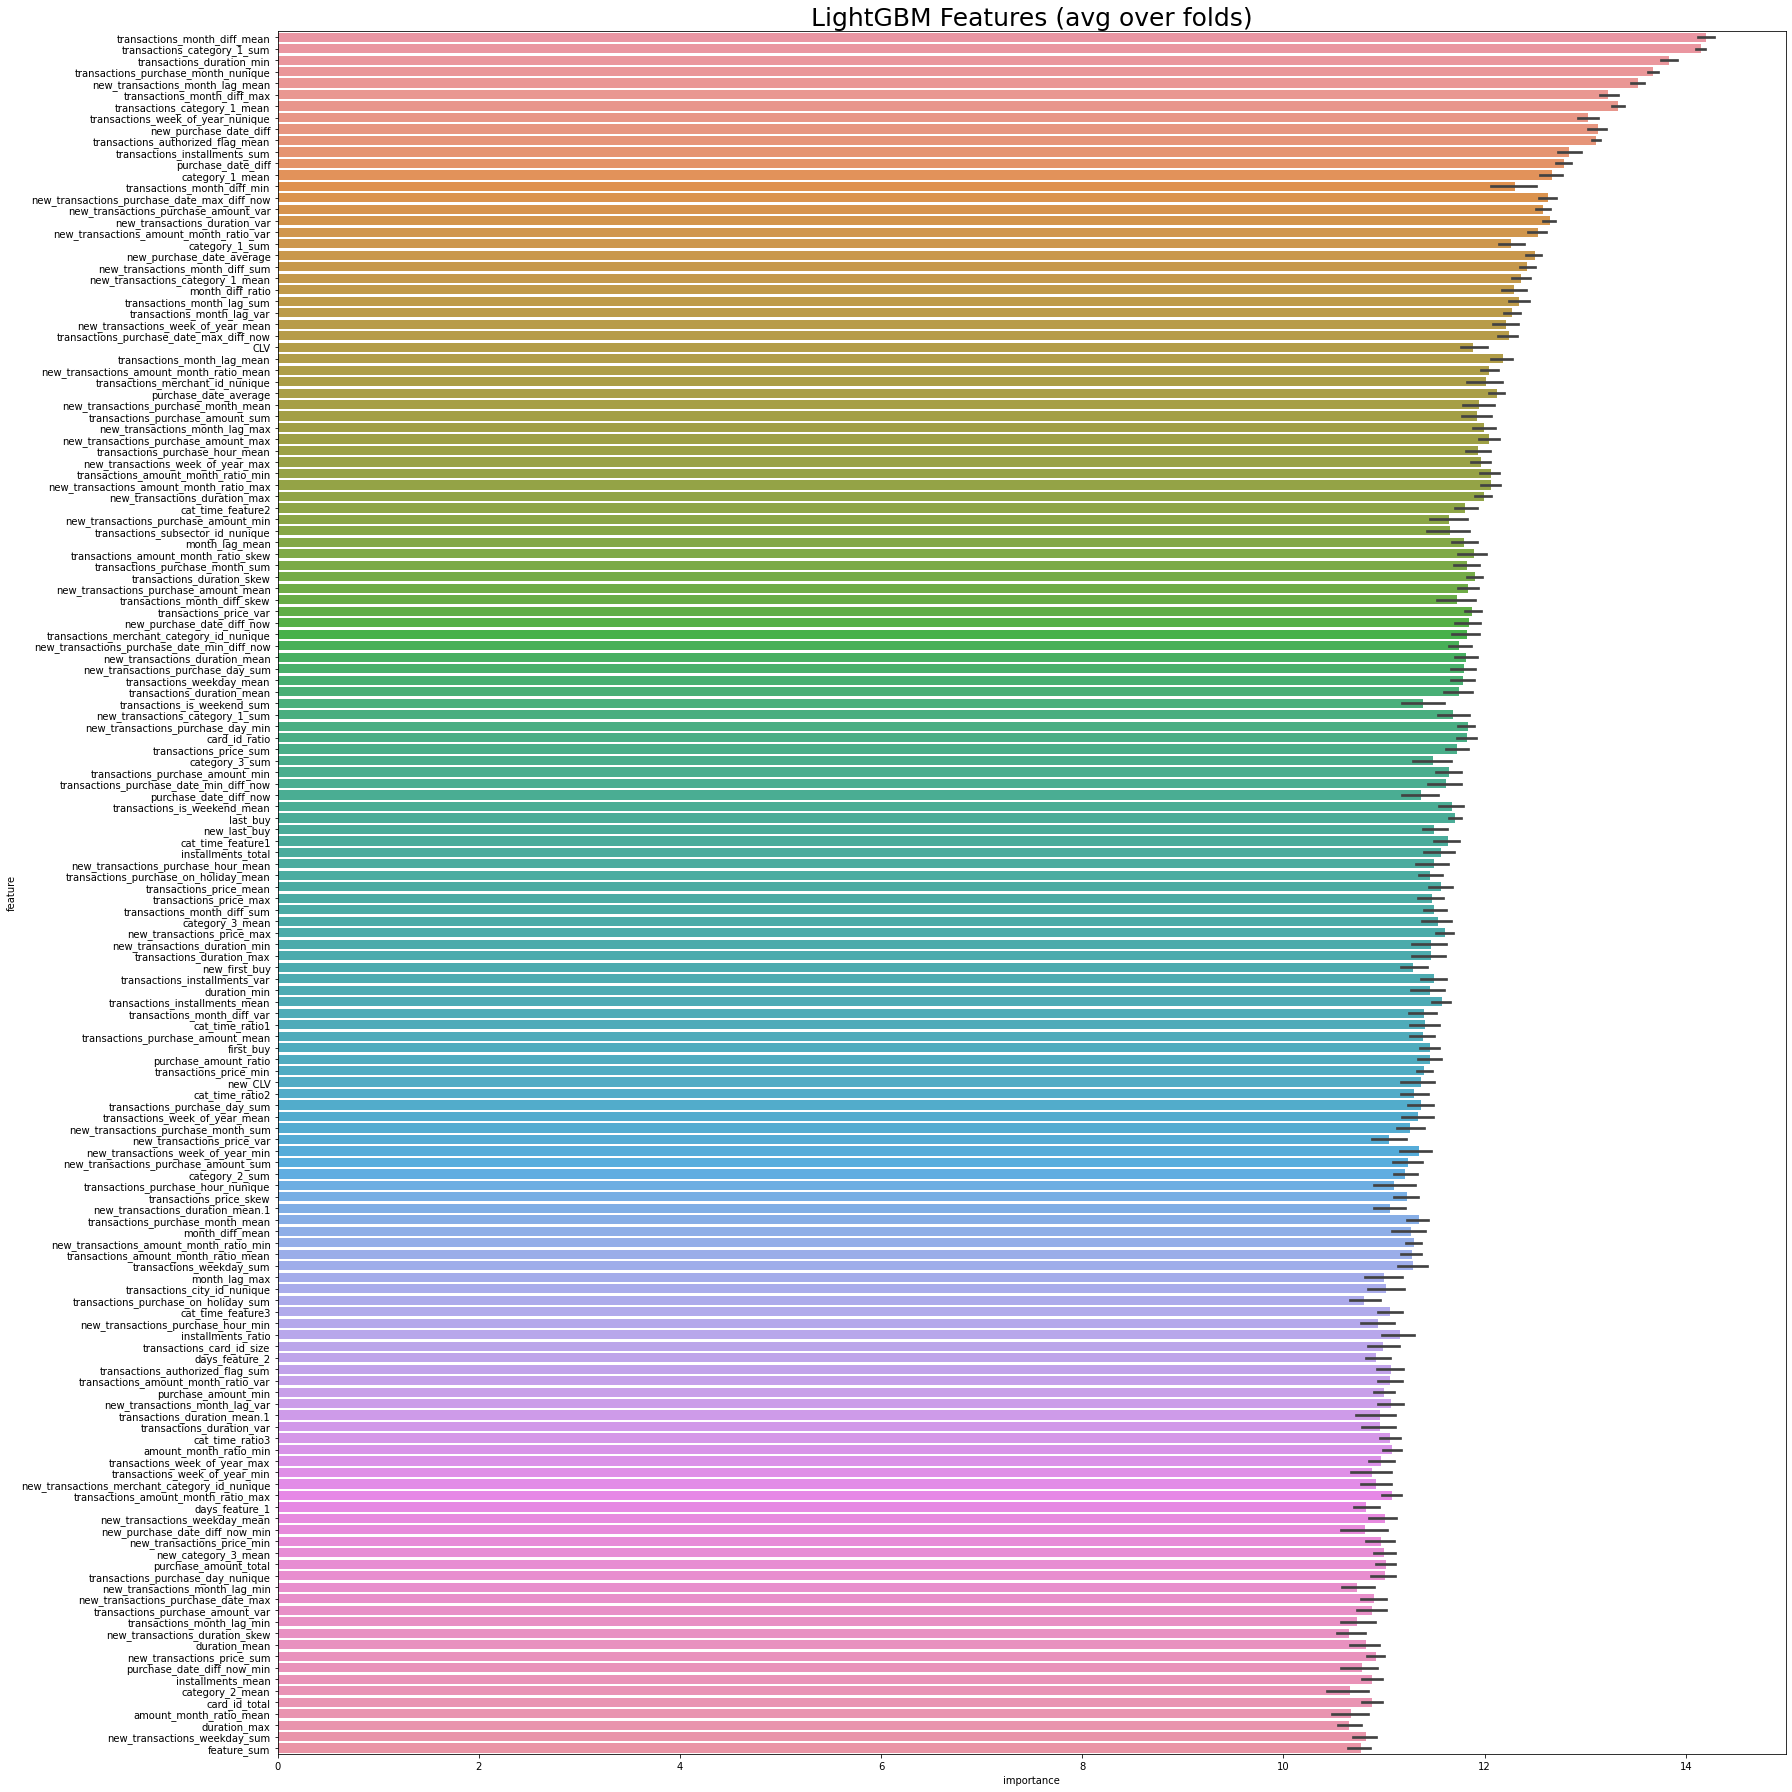

In [ ]:
top_150_features = display_importances(feature_importance_df, 150)

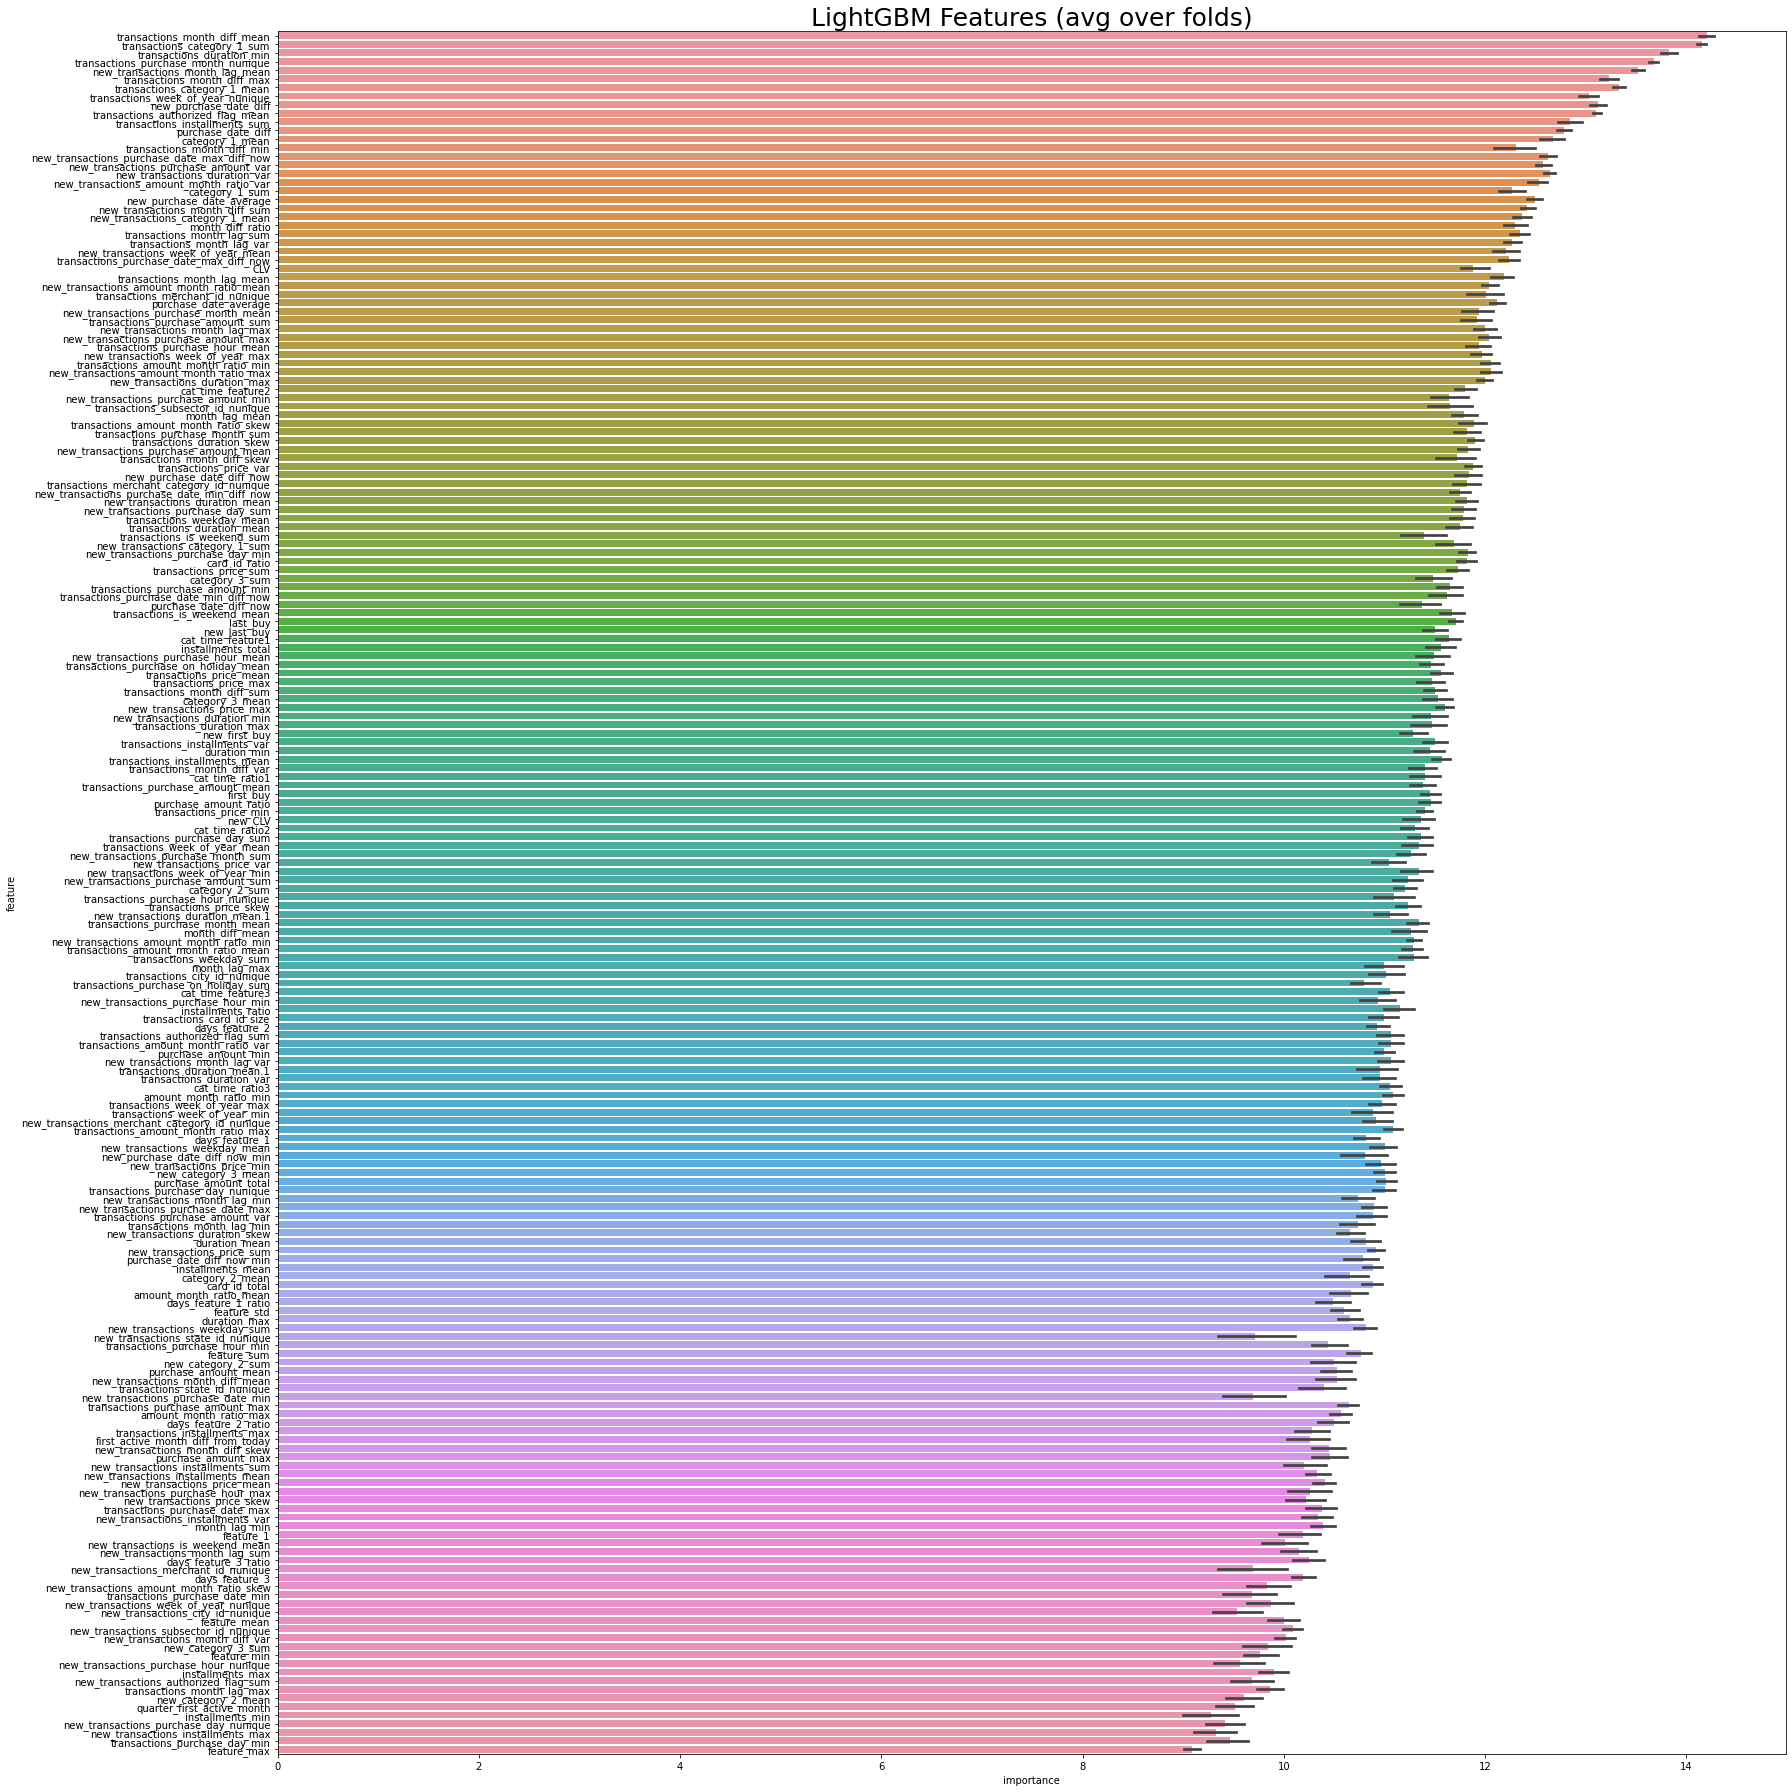

In [ ]:
top_200_features = display_importances(feature_importance_df, 200)

In [ ]:
import pickle

with open('top_150_features.pkl', 'wb') as f:
  pickle.dump(top_150_features,f)

with open('top_200_features.pkl', 'wb') as f:
  pickle.dump(top_200_features, f)


## Stacking using Bayesian Ridge:

Stacking the predictions from above two models to get the final predictions from the Meta model(Bayesian Ridge Regression)

Ref: https://www.kaggle.com/roydatascience/elo-stack-with-goss-boosting

In [ ]:
train_stack = np.vstack([oof,oof_2]).transpose()
test_stack = np.vstack([test_predictions, test_predictions_2]).transpose()

folds_stack = KFold(n_splits=5, shuffle=True, random_state=5)
oof_stack = np.zeros(train_stack.shape[0])
predictions_3 = np.zeros(test_stack.shape[0])

for fold_, (trn_idx, val_idx) in enumerate(folds_stack.split(train_stack,y_train)):
    print("fold {}".format(fold_))
    trn_data, trn_y = train_stack[trn_idx], y_train.iloc[trn_idx].values
    val_data, val_y = train_stack[val_idx], y_train.iloc[val_idx].values
    
    clf_3 = BayesianRidge()
    clf_3.fit(trn_data, trn_y)

    filename = 'Bayesian_Ridge_Stack_Model_' + str(fold_+1) + '.pkl'
    with open(filename, 'wb') as f:
      pickle.dump(clf, f)
    
    oof_stack[val_idx] = clf_3.predict(val_data)
    predictions_3 += clf_3.predict(test_stack) / 5
    
print("CV RMSE:", np.sqrt(mean_squared_error(y_train.values, oof_stack)))

fold 0
fold 1
fold 2
fold 3
fold 4
CV RMSE: 3.6537965683291347


### Getting the Kaggle submission ready


In [ ]:
submission = pd.DataFrame()
submission['card_id'] = card_ids
submission['target'] = test_predictions_2

In [ ]:
submission.head()

,card_id,target
0,C_ID_0ab67a22ab,-3.309115
1,C_ID_130fd0cbdd,-0.269586
2,C_ID_b709037bc5,-1.174518
3,C_ID_d27d835a9f,-0.079542
4,C_ID_2b5e3df5c2,-0.846738


In [ ]:
submission.to_csv('submission_bayesian_ridge.csv', index=0)

## Results:

In [ ]:
table = PrettyTable(['Model','CV RMSE'])
table.add_row(['LGBM with StratifiedKFold', 3.65708])
table.add_row(['LGBM with RepeatedKFold', 3.65559])
table.add_row(['Stacked Bayesian Ridge Regression', 3.65379])
print(table)

+-----------------------------------+---------+
|               Model               | CV RMSE |
+-----------------------------------+---------+
|     LGBM with StratifiedKFold     | 3.65708 |
|      LGBM with RepeatedKFold      | 3.65559 |
| Stacked Bayesian Ridge Regression | 3.65379 |
+-----------------------------------+---------+


The Kaggle submission on Bayesian Ridge stacked model gave a private score of 3.61559.
<br> 
This was the best of all models.

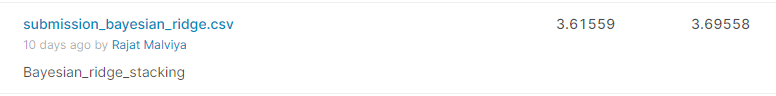